# Camera Caliberation using Direct Linear Transform (DLT)

## Distortion :

Pinhole cameras introduce significant distortion to images. Two major kinds of distortion are radial distortion and tangential distortion.

Radial distortion causes straight lines to appear curved. Radial distortion becomes larger the farther points are from the center of the image.

Radial distortion can be represented as follows:

    xdistorted=x(1+k1r^2+k^2r^4+k3r^6)
    ydistorted=y(1+k1r^2+k2r^4+k3r^6)

tangential distortion occurs because the image-taking lense is not aligned perfectly parallel to the imaging plane. So, some areas in the image may look nearer than expected. The amount of tangential distortion can be represented as below:

    xdistorted=x+(2*p1*x*y+p2(r^2+2*x^2))
    ydistorted=y+ p1(r^2+2*y^2)+2*p2*xy)

We need to find five parameters, known as distortion coefficients given by:

    Distortioncoefficients=(k1,k2,p1,p2,k3)

We need to some other information, like the intrinsic and extrinsic parameters of the camera. Intrinsic parameters are specific to a camera. They include information like focal length ( fx,fy) and optical centers ( cx,cy).

    cameramatrix=[[fx,0,cx],[0,fy,cy],[0,0,1]]

Extrinsic parameters corresponds to rotation and translation vectors which translates a coordinates of a 3D point to a coordinate system.

To find these parameters, we provide some sample images of a well defined pattern (e.g. a chess board). We find some specific points of which we already know the relative positions (e.g. square corners in the chess board). We know the coordinates of these points in real world space and we know the coordinates in the image, so we can solve for the distortion coefficients.

In [29]:
import cv2
import numpy as np
from statistics import mean
import math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")

def getXY(w_pt, i_pt):
    X_list = [-w_pt[0], -w_pt[1], -w_pt[2], -1, 0, 0, 0, 0,
              i_pt[0]*w_pt[0], i_pt[0]*w_pt[1], i_pt[0]*w_pt[2], i_pt[0]]
    Y_list = [0, 0, 0, 0, -w_pt[0], -w_pt[1], -w_pt[2], -1, 
             i_pt[1]*w_pt[0], i_pt[1]*w_pt[1], i_pt[1]*w_pt[2], i_pt[1]]
    return X_list, Y_list

def normalizePoints(i_points):
    mean_X = mean(i_points[:][0])
    mean_Y = mean(i_points[:][1])
    np_X = i_points[:, 0] - mean_X
    np_Y = i_points[:, 1] - mean_Y
    dist = []
    for x,y in zip(np_X,np_Y):
        dist.append(math.sqrt(x**2 + y**2))
    mean_dist = mean(dist)
    scale = math.sqrt(2)/mean_dist
    T = [[scale, 0, -scale*mean_X], [0, scale, -scale*mean_Y], [0, 0, 1]]
    H_i_points = np.c_[ i_points, np.ones(len(img_points))]
    H_i_points = [np.dot(T, x) for x in H_i_points]
    H_i_points = np.delete(H_i_points, -1, axis = 1)
    return H_i_points

def reprojection_error(objpoints3d, imgpoints2d, rvecs, tvecs, mtx):
    mean_error = 0
    for i in range(len(objpoints3d)):
        projected_point = projectOnImg(objpoints3d[i], rvecs, tvecs, mtx)
        #imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(np.float32(imgpoints2d[i]),np.float32(projected_point), cv2.NORM_L2)
        mean_error += error
    
    print ("total error: ", mean_error/len(objpoints3d))
    return mean_error/len(objpoints3d)

def projectOnImg(objpoint, rvecs, tvecs, mtx):
    #dst, jacobian = cv2.Rodrigues(rvecs)
    P = np.dot(mtx, rvecs)
    t = np.dot(mtx,tvecs)
    #print(P.shape, mtx.shape)
    xy = np.dot(P,np.c_[objpoint]) + t
    xy = (xy/xy[2][0])
    return [int(xy[0][0]), int(xy[1][0])]
                        
def executeRANSAC(world3d, img2d, max_iters, samples_to_fit, error_thresh):
    best_points = None
    min_err = 0
    num_samples = img2d.shape[0]
    cam_mat = []
    rot_mat = []
    t_mat = []
    for i in range(max_iters):
        sample = np.random.choice(num_samples, size=samples_to_fit, replace=False)
        mtx, rvecs, tvecs, P, X = findProjectionMatrix(world3d[sample], img2d[sample])
        err = reprojection_error(world3d[sample], img2d[sample], rvecs, tvecs, mtx)
        if err > error_thresh:
            continue
        best_points = sample
        min_err = err
        cam_mat = mtx
        rot_mat = rvecs
        t_mat = tvecs
    return best_points, min_err, cam_mat, rot_mat, t_mat

def findProjectionMatrix(world3d, img2d):
    M = []
    for i in range (6):
        X_list, Y_list = getXY(world_points[(i*119)%38], norm_img_points[(i*119)%38])
        #X_list, Y_list = getXY(world_points[i], norm_img_points[i])
        M.append(X_list)
        M.append(Y_list)
    u, s, vh = np.linalg.svd(M, full_matrices=True)
    v = vh.transpose()
    P = np.array([v[0:4,11], v[4:8,11], v[8:12,11]])
    H_inf = P[0:3,0:3]
    H_inf_inv = np.linalg.inv(H_inf)
    m4 = P[:, 3]
    X_minus = np.dot(H_inf_inv, m4)
    X = (-1)*X_minus
    Q, R = np.linalg.qr(H_inf_inv)
    np.allclose(H_inf_inv, np.dot(Q, R))  # a does equal qr
    Rot_inv = Q
    rvec = np.linalg.inv(Q)
    K_inv = R
    K = np.linalg.inv(K_inv)
    K = K/K[2,2]
    tvec = np.dot(rvec,X_minus)
    return K, rvec, tvec, P, X


def plot3dview(points_3d, camera_center):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='blue',
        marker='o', s=10, depthshade=0)
    camera_center = camera_center.squeeze()
    ax.scatter(camera_center[0],  camera_center[1], camera_center[2], c='red',
        marker='x', s=20, depthshade=0)

    # draw vertical lines connecting each point to ground
    min_z = min(points_3d[:, 2])
    for p in points_3d:
        x, y, z = p
        ax.plot3D(xs=[x, x], ys=[y, y], zs=[z, min_z], c='black', linewidth=1)
    x, y, z = camera_center
    ax.plot3D(xs=[x, x], ys=[y, y], zs=[z, min_z], c='black', linewidth=1)
    
def evaluate_points(M, points_2d, points_3d):
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

def visualize_points(actual_pts, projected_pts):
    _, ax = plt.subplots()
    ax.scatter(actual_pts[:, 0], actual_pts[:, 1], c='red', marker='o',
        label='Actual points')
    ax.scatter(projected_pts[:, 0], projected_pts[:, 1], c='green', marker='+',
        label='Projected points')
    ax.legend()

## Steps :
1. For the given image, find the corners of the chessboard squares in the image. These correspond to 2D image points. These points should be on different planes of the 3D object.
2. Normalize these image points using L2-norm.
3. Define world points corresponding to the 2D image points defined in step-1.
4. For part-1, get 6 image points randomly and the corresponding world points.
5. For part-2, find 6 points from the defined image and world points such that they minimize the projection error.

In [36]:

img = cv2.imread("dataset/calib-object.jpg")
'''
plt.figure(figsize=(10,10))
plt.grid(b=None)
plt.imshow(img)
plt.show()
'''
img_points = [(424,1720), (616,1698), (799,1675), (972,1658), (1135,1639), (1280,1623), (1411,1604),(1544,1590),
              (1600,1610),(1793,1626),(1931,1644),(2082,1663),(2244,1684),(2422,1707),(2617,1730),
             (442,1934),(632,1903),(811,1875),(979,1848),(1135,1825),(1279,1801),(1414,1779),(1546,1760),
              (1665,1783),(1793,1805),(1929,1830),(2077,1855),(2238,1885),(2413,1913),(2598,1947),
             (1544,1926),(1544,2085),(1542,2247),(1546,2398),(1545,2555),(1545,2700),(1543,2850),(1545,2994)]
img_points = np.asarray(img_points)
world_points = [(0,0,7),(0,0,6),(0,0,5),(0,0,4),(0,0,3),(0,0,2),(0,0,1),(0,0,0),
               (1,0,0),(2,0,0),(3,0,0),(4,0,0),(5,0,0),(6,0,0),(7,0,0),
               (0,1,7),(0,1,6),(0,1,5),(0,1,4),(0,1,3),(0,1,2),(0,1,1),(0,1,0),
               (1,1,0),(2,1,0),(3,1,0),(4,1,0),(5,1,0),(6,1,0),(7,1,0),
               (0,2,0),(0,3,0),(0,4,0),(0,5,0),(0,6,0),(0,7,0),(0,8,0),(0,9,0),]
world_points = np.asarray(world_points)

'''
#### Zoom-1x
img_points = [[1684,2398], [2058,2293], [2065,1916], [1688,1936], [1014,2226], [1000,1896]]
img_points = np.asarray(img_points)

world_points = [[0,0,0], [8.1,0,0], [8.1,0,5.9], [0,0,5.9], [0,17.1,0], [0,17.1, 5.9]]
world_points = np.asarray(world_points)
####
'''
norm_img_points = img_points#ormalizePoints(img_points)

M = []
for i in range (6):
    X_list, Y_list = getXY(world_points[(i*119)%38], norm_img_points[(i*119)%38])
    #X_list, Y_list = getXY(world_points[i], norm_img_points[i])
    #print((i*119)%38)
    M.append(X_list)
    M.append(Y_list)

best_points, min_err, cam_mat, rot_mat, t_mat = executeRANSAC(world_points, norm_img_points, 10, 6, 2600)
print("Minimum error :\n", min_err)
print("Camera matrix :\n", cam_mat)
print("Rotation matrix for 1st image:\n",rot_mat)
print("Translation matrix for 1st image :\n",t_mat)

total error:  2337.810549998138
total error:  2648.7420177898175
total error:  2393.5828639704637
total error:  2361.8913388176466
total error:  2421.6613496993127
total error:  2811.708618116976
total error:  2325.2716409801455
total error:  2797.0308198757725
total error:  2588.8889090405637
total error:  2308.8102858326415
Minimum error :
 2308.8102858326415
Camera matrix :
 [[3.36210511e+03 1.68710761e+01 1.47164263e+03]
 [0.00000000e+00 3.35838256e+03 1.91906130e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation matrix for 1st image:
 [[-6.74268232e-01 -6.35400319e-04  7.38486254e-01]
 [-1.59156767e-01 -9.76374586e-01 -1.46156736e-01]
 [ 7.21132078e-01 -2.16083929e-01  6.58237238e-01]]
Translation matrix for 1st image :
 [ -0.41428073   1.92997331 -19.8987327 ]


6. Visualize the 3D points, actual points and projected points.

Projection matrix :
 [[-2.72067705e-02 -7.57862780e-03  7.76554901e-02 -6.89944949e-01]
 [ 1.91237521e-02 -8.31631660e-02  1.73892155e-02 -7.13837188e-01]
 [ 1.62361154e-05 -4.86507771e-06  1.48200532e-05 -4.48015184e-04]]


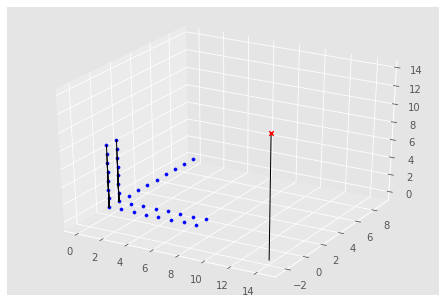

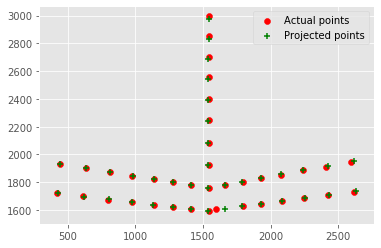

In [37]:
K, rvec, tvec, P, cam_center = findProjectionMatrix(world_points[best_points], norm_img_points[best_points])
print("Projection matrix :\n", P)
plot3dview(world_points, cam_center)
points_3d_proj, residual = evaluate_points(P, norm_img_points, world_points)
visualize_points(norm_img_points, points_3d_proj)

## Finding distortion parameters:
- Define image points corresponding to ixel positions and corresponding world points.
- Using OpenCV's caliberateCamera() find camera matrix, rotation matrix, translation matrix, 
- Undistort the image using OpenCV's undistort().

Camera matrix :
 [[ 3.78162575e+03  0.00000000e+00  1.24876118e+03]
 [ 0.00000000e+00  3.70979681e+03 -5.53100289e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Distortion matrix :
 [[-0.21095658  1.30517105  0.01271407  0.02247538 -3.28157164]]
Rotation matrix for 1st image:
 [array([[-1.35020097],
       [ 0.52416517],
       [ 0.62911191]])]
Translation matrix for 1st image :
 [array([[-1.59737048],
       [ 1.46180434],
       [22.46078701]])]
[[ 3.68009302e+03  0.00000000e+00  1.27115943e+03]
 [ 0.00000000e+00  3.62316724e+03 -4.99724021e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


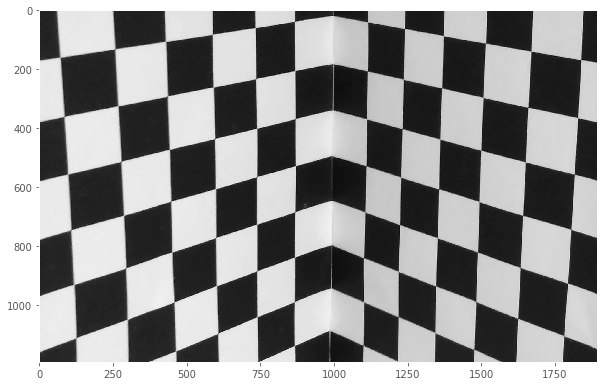

True

In [38]:
##### Distortion parameters

undistort_img = cv2.imread("dataset/Fig1.png")
'''
plt.figure(figsize=(10,10))
plt.grid(b=None)
plt.imshow(undistort_img)
plt.show()
'''
img_points = np.array([[1100,213], [1360, 275], [1655, 339],[1221, 581], [1497 ,671], [1815, 763],[1100 ,703 ], [1353 ,789 ], [1645 ,897],
             [856,209], [579,265], [727,408], [433,478], [274,517],[859,538],[588,615],[730,739],[443,831],[121,940]], dtype='float32')

world_points = np.array([[1,0,0], [3, 0, 0] ,[ 5, 0, 0], [2,0,2 ],[ 4,0,2] ,[ 6,0,2],[1,0,3], [3,0, 3 ],[ 5,0,3],
               [0,1,0], [0,3,0],[0,2,1], [0,4,1], [0,5,1], [0,1,2], [0,3,2], [0,2,3], [0,4,3], [0,6,3]], dtype='float32')

#img_points = np.asarray(img_points)
#world_points = np.asarray(world_points)


undistort_img = cv2.cvtColor(undistort_img, cv2.COLOR_BGR2GRAY)
cam_mat = np.array([[2000, 0, 0], [0, 2000, 0], [0, 0, 1]], dtype='float32')

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([world_points], [img_points], undistort_img.shape[::-1], cam_mat, None, flags = cv2.CALIB_USE_INTRINSIC_GUESS)
print("Camera matrix :\n", mtx)
print("Distortion matrix :\n",dist)
print("Rotation matrix for 1st image:\n",rvecs)
print("Translation matrix for 1st image :\n",tvecs)

##### using cv2.undistort #######
h,  w = undistort_img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
print(newcameramtx)
dst = cv2.undistort(undistort_img, mtx, dist, None, newcameramtx)

x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
################################
'''

##### using remaping #######
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv2.remap(undistort_img,mapx,mapy,cv2.INTER_LINEAR)

x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
###############
'''
plt.figure(figsize=(10,10))
plt.grid(b=None)
plt.imshow(dst, cmap = plt.get_cmap('gray'))
plt.show()
cv2.imwrite('calibresult.png',dst)
#cv2.imwrite("img.jpg", dst)
#cv2.waitKey(500)
